In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torchsummary import summary
import numpy as np
import time
import os
import random
from google.colab import drive

# Get Faster R-CNN models
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

# Imports for Data
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms, Resize, ToTensor
from torchvision.transforms.functional import to_pil_image, convert_image_dtype
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

# Set up drive storage and device
drive.mount('/content/drive')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)



cpu


In [ ]:
# Get models set up
classes = FasterRCNN_ResNet50_FPN_Weights.DEFAULT.meta["categories"]
fast_rcnn = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
fast_rcnn.eval()

yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-10-31 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [ ]:
# Experiment 1: Testing models on random images

# Images
imgs = ["alan.jpg", "cats2.jpg", "cats.jpg", "shed.jpg", "market.jpg"]
img_tensors = []
for path in imgs:
    image = read_image(path)
    image = image / 255.0  # Normalise the image to [0, 1]
    img_tensors.append(image)

# Inference
fast_rcnn_results = fast_rcnn(img_tensors)
yolo_results = yolo(imgs)



In [ ]:
# Display Results with bounding boxes and captions
def show_bb(img, boxes, captions):
    img = (img * 255).to(torch.uint8)
    img = draw_bounding_boxes(img, boxes, captions, width=1)
    img = img.detach()
    img = to_pil_image(img)
    display(img)

# Display the results for each image from faster r-cnn
yolo_results.print()
for i, result in enumerate(fast_rcnn_results):

    # Get captions, labels, confidences
    confs = result["scores"]
    labels = result["labels"]
    captions = []
    for label, conf in zip(labels, confs):
        captions.append(f"{classes[label]} {(conf * 100).round()}")

    # Display
    boxes = result["boxes"]
    show_bb(img_tensors[i], boxes, captions)

# Display the YOLO results
yolo_results.show()

image 1/5: 3024x4032 1 person, 2 cats, 1 cup, 1 chair, 1 couch, 1 remote, 1 refrigerator, 2 vases
image 2/5: 3024x4032 (no detections)
image 3/5: 3024x4032 3 cars, 1 cat, 2 dogs
image 4/5: 4032x3024 1 bottle
image 5/5: 3024x4032 18 persons, 4 umbrellas, 2 handbags, 1 dining table
Speed: 144.1ms pre-process, 395.9ms inference, 2.5ms NMS per image at shape (5, 3, 640, 640)


Labels: ['cat 100.0', 'couch 99.0', 'chair 97.0', 'chair 96.0', 'refrigerator 94.0', 'vase 92.0', 'person 91.0', 'remote 80.0', 'cat 68.0', 'clock 68.0', 'bottle 48.0', 'remote 45.0', 'vase 41.0', 'couch 40.0', 'bowl 38.0', 'dining table 38.0', 'chair 38.0', 'chair 36.0', 'refrigerator 35.0', 'cell phone 25.0', 'remote 24.0', 'remote 24.0', 'cat 23.0', 'cell phone 22.0', 'tv 20.0', 'dog 15.0', 'person 14.0', 'vase 13.0', 'handbag 13.0', 'chair 12.0', 'vase 12.0', 'couch 11.0', 'cat 10.0', 'cat 9.0', 'person 9.0', 'couch 8.0', 'chair 7.0', 'dining table 6.0', 'chair 6.0', 'cat 6.0', 'mouse 6.0', 'wine glass 5.0', 'cat 5.0']
Labels: ['truck 34.0', 'cat 33.0', 'bench 15.0', 'cat 14.0', 'truck 13.0', 'car 11.0', 'car 10.0', 'airplane 8.0', 'truck 7.0', 'truck 7.0', 'motorcycle 7.0', 'car 6.0', 'skateboard 6.0', 'motorcycle 5.0']
Labels: ['car 99.0', 'car 99.0', 'cat 99.0', 'car 99.0', 'cat 99.0', 'zebra 86.0', 'cat 34.0', 'car 30.0', 'car 23.0', 'dog 20.0', 'dog 8.0']
Labels: ['clock 97.0'

In [ ]:
# Experiment 2: Testing models on bus dataset

# Get Data for R-CNN
class BusDataset(Dataset):
    def __init__(self, data_root):
        self.root = data_root
        self.image_root = data_root + "/images/images"

        # Read CSV data from path
        data = pd.read_csv(data_root + "/subset.csv")

        # Set up x and y from CSV stuff
        x = data["ImageID"]
        y = data[["LabelName", "XMin", "XMax", "YMin", "YMax"]]
        self.x, self.y = x, y

    def __getitem__(self, ix):

        # Retrieve image using ID
        img_id = self.x.iloc[ix]
        path = self.image_root + f"/{img_id}.jpg"
        img = read_image(path)
        img = img / 255.0
        label = self.y.iloc[ix].values
        return img, label

    def __len__(self):
        return len(self.x)

test_dataset = BusDataset("drive/MyDrive/Data/bus_data")


In [ ]:
def area_from_points(min_p, max_p):
    """Calculates the area of a square defined by its min and max point"""
    width = max_p[0] - min_p[0]
    height = max_p[1] - min_p[1]
    return width * height


def compute_IoU(box1, box2):
    """Computes Intersection over Union for two bounding boxes"""

    min1, max1 = (box1[0], box1[2]), (box1[1], box1[3])
    min2, max2 = (box2[0], box2[2]), (box2[1], box2[3])

    i_min = max(min1, min2)
    i_max = min(max1, max2)
    if i_min[0] > i_max[0] or i_min[1] > i_max[1]:
        return 0
    intersection = area_from_points(i_min, i_max)

    area1 = area_from_points(min1, max1)
    area2 = area_from_points(min2, max2)
    union = area1 + area2 - intersection
    return intersection / union


STARTING IMAGE 0...
[88.0, 232.64, 26.547539999999998, 110.50799] [92.19097900390625, 237.64625549316406, 29.66213607788086, 107.4770736694336]
Predicted Box: [92.19097900390625, 237.64625549316406, 29.66213607788086, 107.4770736694336], IoU: 0.9377935107088021
STARTING IMAGE 1...
[40.0, 95.04, 38.763071999999994, 101.552832] [41.491390228271484, 93.1899185180664, 39.848751068115234, 96.10073852539062]
Predicted Box: [41.491390228271484, 93.1899185180664, 39.848751068115234, 96.10073852539062], IoU: 0.8414896972985596
STARTING IMAGE 2...
[73.6, 255.84, 33.205464, 170.839602] [71.90655517578125, 256.0, 25.709230422973633, 165.4081573486328]
Predicted Box: [71.90655517578125, 256.0, 25.709230422973633, 165.4081573486328], IoU: 0.9753005728951032
[73.6, 255.84, 33.205464, 170.839602] [75.26121520996094, 256.0, 93.73786163330078, 166.9886474609375]
Predicted Box: [75.26121520996094, 256.0, 93.73786163330078, 166.9886474609375], IoU: 0.5706411257599696
STARTING IMAGE 3...
STARTING IMAGE 4..

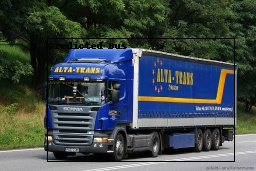

Predicted Box: [47.37031555175781, 234.7322540283203, 38.838279724121094, 161.54269409179688], IoU: 1.0326590514476037
STARTING IMAGE 8...
STARTING IMAGE 9...
[15.2, 217.28, 6.7056640000000005, 214.73984] [27.59095573425293, 211.65830993652344, 10.739130020141602, 215.0823211669922]
Predicted Box: [27.59095573425293, 211.65830993652344, 10.739130020141602, 215.0823211669922], IoU: 0.8947030562055304
STARTING IMAGE 10...
STARTING IMAGE 11...
[77.12, 104.64, 90.080064, 118.719936] [78.24656677246094, 103.59971618652344, 95.06111145019531, 120.10684967041016]
Predicted Box: [78.24656677246094, 103.59971618652344, 95.06111145019531, 120.10684967041016], IoU: 0.8056497017304021
STARTING IMAGE 12...
[137.44, 194.4, 92.59289, 151.80733999999998] [141.68283081054688, 200.85061645507812, 92.55367279052734, 153.11773681640625]
Predicted Box: [141.68283081054688, 200.85061645507812, 92.55367279052734, 153.11773681640625], IoU: 0.8150280773035422
STARTING IMAGE 13...
[0.0, 55.000064, 64.5999839999

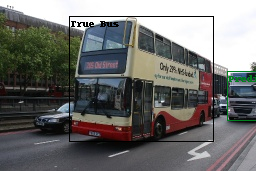

Predicted Box: [227.98574829101562, 256.0, 71.425537109375, 120.94477081298828], IoU: 0
[69.44, 213.76, 16.041339, 141.64442999999997] [71.35618591308594, 144.0808563232422, 17.677349090576172, 141.2220916748047]
Predicted Box: [71.35618591308594, 144.0808563232422, 17.677349090576172, 141.2220916748047], IoU: 0.4956546480009727
STARTING IMAGE 18...
[0.0, 251.52, 3.3600000000000003, 191.840064] [0.0, 250.53359985351562, 6.743547439575195, 192.0]
Predicted Box: [0.0, 250.53359985351562, 6.743547439575195, 192.0], IoU: 0.979042122455321
[0.0, 251.52, 3.3600000000000003, 191.840064] [97.24107360839844, 245.61331176757812, 55.12245178222656, 190.10308837890625]
Predicted Box: [97.24107360839844, 245.61331176757812, 55.12245178222656, 190.10308837890625], IoU: 0.4224605645454552
[0.0, 251.52, 3.3600000000000003, 191.840064] [0.0, 135.49147033691406, 32.09443283081055, 187.8683624267578]
Predicted Box: [0.0, 135.49147033691406, 32.09443283081055, 187.8683624267578], IoU: 0.44521397328647266


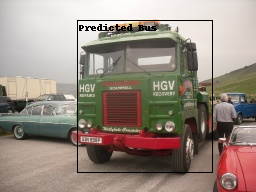

Predicted Box: [77.39015197753906, 212.9402313232422, 20.914306640625, 172.22030639648438], IoU: 0.858079216464331
STARTING IMAGE 32...
[0.0, 232.48, 23.572368, 62.057952] [190.5763702392578, 232.42800903320312, 26.829330444335938, 60.54387664794922]
[[0.0, 232.48, 23.572368, 62.057952], [190.5763702392578, 232.42800903320312, 26.829330444335938, 60.54387664794922]]
[[0.0, 23.572368, 232.48, 62.057952], [190.5763702392578, 26.829330444335938, 232.42800903320312, 60.54387664794922]]


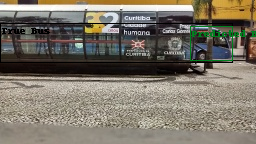

Predicted Box: [190.5763702392578, 232.42800903320312, 26.829330444335938, 60.54387664794922], IoU: 0.1577052345946503
[0.0, 232.48, 23.572368, 62.057952] [29.062559127807617, 218.8636016845703, 5.471531867980957, 73.24354553222656]
Predicted Box: [29.062559127807617, 218.8636016845703, 5.471531867980957, 73.24354553222656], IoU: 1.4376901763981587
STARTING IMAGE 33...
STARTING IMAGE 34...
[70.4, 240.16, 85.92, 153.12] [50.85593032836914, 240.55052185058594, 85.85247039794922, 153.70248413085938]
Predicted Box: [50.85593032836914, 240.55052185058594, 85.85247039794922, 153.70248413085938], IoU: 0.8863387792258075
STARTING IMAGE 35...
STARTING IMAGE 36...
STARTING IMAGE 37...
STARTING IMAGE 38...
[0.0, 255.2, 26.000064000000002, 145.599936] [28.983524322509766, 256.0, 15.015490531921387, 147.41073608398438]


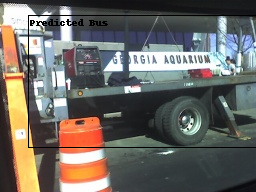

Predicted Box: [28.983524322509766, 256.0, 15.015490531921387, 147.41073608398438], IoU: 0.9517652393929602
STARTING IMAGE 39...
STARTING IMAGE 40...
[0.0, 255.04, 38.009484, 152.839656] [3.8065805435180664, 212.18333435058594, 26.18260955810547, 147.34527587890625]


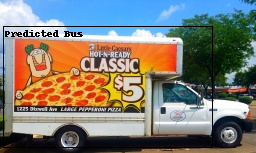

Predicted Box: [3.8065805435180664, 212.18333435058594, 26.18260955810547, 147.34527587890625], IoU: 0.8620923175710423
STARTING IMAGE 41...
STARTING IMAGE 42...
[41.250048, 165.750016, 67.24992, 149.000064] [37.685184478759766, 202.33177185058594, 75.92914581298828, 152.48013305664062]
Predicted Box: [37.685184478759766, 202.33177185058594, 75.92914581298828, 152.48013305664062], IoU: 0.8075217650196028
STARTING IMAGE 43...
[0.0, 255.84, 0.0, 105.12] [0.0, 166.34129333496094, 5.868398189544678, 110.75730895996094]


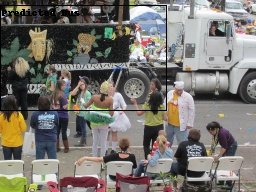

Predicted Box: [0.0, 166.34129333496094, 5.868398189544678, 110.75730895996094], IoU: 0.6487477292266339
STARTING IMAGE 44...
STARTING IMAGE 45...
STARTING IMAGE 46...
[122.88, 231.04, 37.69695, 134.265438] [0.0, 86.88858032226562, 80.7519302368164, 162.12451171875]


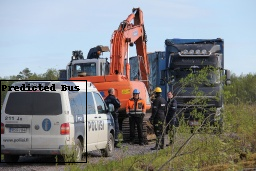

Predicted Box: [0.0, 86.88858032226562, 80.7519302368164, 162.12451171875], IoU: 0
STARTING IMAGE 47...
[16.16, 229.12, 18.080064, 179.52] [20.51434898376465, 225.38729858398438, 13.459321022033691, 173.63824462890625]
Predicted Box: [20.51434898376465, 225.38729858398438, 13.459321022033691, 173.63824462890625], IoU: 0.9545110846094006
STARTING IMAGE 48...
[0.0, 96.16, 110.152452, 167.30398] [0.0, 99.88611602783203, 111.43588256835938, 167.00961303710938]
Predicted Box: [0.0, 99.88611602783203, 111.43588256835938, 167.00961303710938], IoU: 0.9467468993593697
STARTING IMAGE 49...
[45.28, 206.88, 48.123846, 136.029987] [41.86128616333008, 203.14556884765625, 51.08031463623047, 133.85057067871094]
Predicted Box: [41.86128616333008, 203.14556884765625, 51.08031463623047, 133.85057067871094], IoU: 0.9651560562103371
[45.28, 206.88, 48.123846, 136.029987] [189.87646484375, 255.12171936035156, 56.746620178222656, 112.7198715209961]
[[45.28, 206.88, 48.123846, 136.029987], [189.87646484375, 2

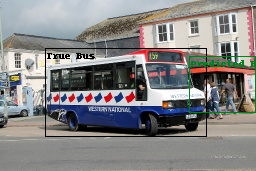

Predicted Box: [189.87646484375, 255.12171936035156, 56.746620178222656, 112.7198715209961], IoU: 0.08165574750568139


(75.0, 399.38265323638916)

In [ ]:
def convert_boxes(boxes):
    """Converts bounding boxes from xxyy to xyxy format"""
    new_boxes = []
    for box in boxes:
        new_box = [box[0], box[2], box[1], box[3]]
        new_boxes.append(new_box)
    return new_boxes

def evaluate_fast_rcnn(model, dataset):
    correct = 0
    total = 0
    confidence_thresh = .3
    iou_thresh = .4

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient calculation
    start = time.time()
    for i in range(50):
        print(f"STARTING IMAGE {i}...")

        # Get image, label, and prediction
        img, label = dataset[i]
        prediction = model([img])[0]
        true_class = label[0]
        true_box = label[1:5]
        height, width = img.size()[1], img.size()[2]

        # Find which predicted boxes are buses, with conf > thresh
        bus_indexes = []
        pred_classes = [classes[label] for label in prediction["labels"]]
        for j in range(len(pred_classes)):
            if pred_classes[j] == "bus" and prediction["scores"][j] > confidence_thresh:
                bus_indexes.append(j)

        # Adjust predicted bounding box to size of image
        true_box = [val * width if idx < 2 else val * height for idx, val in enumerate(true_box)]

        # For each confident detection, check if it was correct
        for bus_index in bus_indexes:

            # Get our predicted bounding box for a bus
            predict_box = prediction["boxes"][bus_index].tolist()
            predict_box = convert_boxes([predict_box])[0]

            # Compute predicted IoU with true bounding box
            print(true_box, predict_box)
            iou = compute_IoU(true_box, predict_box)
            if iou > iou_thresh and true_class == "Bus":
                correct += 1

            # Display our wrong guess, if there is no bus
            elif true_class != "Bus":
                boxes = convert_boxes([predict_box])
                show_bb(img, torch.tensor(boxes), ["Predicted Bus"])

            # Display the bad guess, if we are confident and missed
            elif true_class == "Bus" and iou < iou_thresh:
                print([true_box, predict_box])
                boxes = convert_boxes([true_box, predict_box])
                print(boxes)
                show_bb(img, torch.tensor(boxes), ["True Bus", "Predicted Bus"])

            print(f"Predicted Box: {predict_box}, IoU: {iou}")
            total += 1

    # Calculate accuracy
    accuracy = (correct / total) * 100.0
    testing_time = time.time() - start
    return accuracy, testing_time

# Run through our tests
evaluate_fast_rcnn(fast_rcnn, test_dataset)

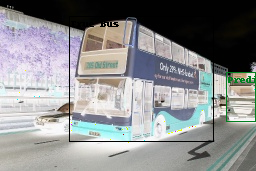

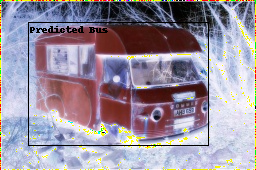

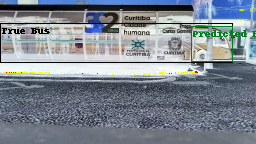

(86.95652173913044, 18.42955446243286)

In [ ]:
class YoloDataset(Dataset):
    def __init__(self, data_root):
        self.root = data_root
        self.image_root = data_root + "/images/images"

        # Read CSV data from path
        data = pd.read_csv(data_root + "/subset.csv")

        # Set up x and y from CSV stuff
        x = data["ImageID"]
        y = data[["LabelName", "XMin", "XMax", "YMin", "YMax"]]
        self.x, self.y = x, y

    def __getitem__(self, ix):

        # Retrieve image using ID
        img_id = self.x.iloc[ix]
        path = self.image_root + f"/{img_id}.jpg"
        img_size = read_image(path).size()
        label = self.y.iloc[ix].values
        return path, (img_size[1], img_size[2]), label

    def __len__(self):
        return len(self.x)


def evaluate_yoloV5(model, dataset):

    accurate_predictions = 0
    total_bus_predictions = 0
    confidence_thresh = 0.3
    iou_thresh = 0.4

    start = time.time()
    for i in range(50):

          img, size, true_label = dataset[i]
          height, width = size

          # Get the true class and true box dimensions
          true_class = true_label[0]
          true_box = true_label[1:5]
          # Adjust predicted bounding box to size of image
          true_box = [val * width if idx < 2 else val * height for idx, val in enumerate(true_box)]

          # Compute and store the results for the yolo model
          results = model(img)
          label_table = results.pandas().xyxy[0]

          """
              Count the total number of true predictions
              A true prediction consists of:
                  1) A confident "bus" when the image contains a bus, with
                  2) An accurate bounding box
          """
          for index, row in label_table.iterrows():
                # Only loop through the predictions that are a confident "bus"
                if row["name"] == "bus" and row["confidence"] > confidence_thresh:
                      total_bus_predictions += 1
                      pred_box = [row["xmin"], row["xmax"], row["ymin"], row["ymax"]]
                      iou = compute_IoU(pred_box, true_box)

                      if iou > iou_thresh and true_class == "Bus":
                            # Increase accuracy if IoU passes our threshold
                            accurate_predictions += 1
                      elif true_class != "Bus":
                            # Display the incorrect bus prediction box
                            draw_box = convert_boxes([pred_box])
                            img = read_image(img)
                            show_bb(img, torch.tensor(draw_box), ["Predicted Bus"])
                      else:
                            # Display the true bus bounding box and our incorrect bus prediction box
                            draw_boxes = convert_boxes([true_box, pred_box])
                            img = read_image(img)
                            show_bb(img, torch.tensor(draw_boxes), ["True Bus", "Predicted Bus"])



    accuracy = (accurate_predictions / total_bus_predictions) * 100.0
    testing_time = time.time() - start
    return accuracy, testing_time

    # What the results format should look like:
    #     xmin    ymin    xmax   ymax  confidence  class    name
    # 0  749.50   43.50  1148.0  704.5    0.874023      0  person
    # 2  114.75  195.75  1095.0  708.0    0.624512      0  person
    # 3  986.00  304.00  1028.0  420.0    0.286865     27     tie

yolo_dataset = YoloDataset("drive/MyDrive/Data/bus_data")
evaluate_yoloV5(yolo, yolo_dataset)

In [ ]:


# Create a list of images we were able to download
downloaded_files = os.listdir("drive/MyDrive/Data/bus_data/images/images")

# Create a new DataFrame with only the downloaded images (12,308)
original_df = pd.read_csv("drive/MyDrive/Data/bus_data/df.csv")
original_df['ImageID'] = original_df['ImageID'] + '.jpg'  # Add file extension so we can compare
downloaded_df = original_df[original_df['ImageID'].isin(downloaded_files)]
downloaded_df['ImageID'] = downloaded_df['ImageID'].str.rstrip('.jpg')
downloaded_df = downloaded_df.drop_duplicates(subset=['ImageID'], keep=False)

# Filter down to a subset
size_of_subset = 50
print(downloaded_df["ImageID"].nunique())
subset = random.sample(downloaded_df['ImageID'].tolist(), size_of_subset)
subset_df = downloaded_df[downloaded_df["ImageID"].isin(subset)]
print(subset_df)

# Download to drive
downloaded_df.to_csv('drive/MyDrive/Data/bus_data/subset.csv', index=False)


8473
                ImageID     Source LabelName  Confidence      XMin  ...  \
113    004ad4929992ac10     xclick       Bus           1  0.000000  ...   
393    00e847daf21b5eff     xclick       Bus           1  0.737500  ...   
603    0186e016e570495a     xclick       Bus           1  0.000000  ...   
812    023617a33ddf0e64     xclick       Bus           1  0.000000  ...   
1247   03dbe0e1735485d0     xclick       Bus           1  0.156250  ...   
1631   075767c6e3959ee9     xclick     Truck           1  0.187500  ...   
1934   0a5a3637443652fc  activemil     Truck           1  0.075000  ...   
1952   0a92453ef830a234  activemil       Bus           1  0.221875  ...   
2247   0dfe7f0ec0bb8c09     xclick       Bus           1  0.713125  ...   
4238   22aa1b5f4d006745  activemil     Truck           1  0.651250  ...   
4737   28456cce4e1653f3     xclick       Bus           1  0.352459  ...   
5050   2b7833bff5fde50b  activemil     Truck           1  0.628750  ...   
6494   3b3026be8d88b

<ipython-input-14-8314a1c7ac1d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downloaded_df['ImageID'] = downloaded_df['ImageID'].str.rstrip('.jpg')
